# Re-creation of the market making figures on page 252 of "Algorithmic and High-Frequency Trading" By Cartea et. al.

### Note: These simulations are statistically exact. There is no SDE discretization error. Also, it would be easier in some ways to just step the simulation forward at each time step and draw the necessary random variables. However, Python/NumPy works a lot better if we use vectors. We need to use a bit of knowledge about Poisson processes to pull it off.

### You need numpy 1.16 (the most recent version).

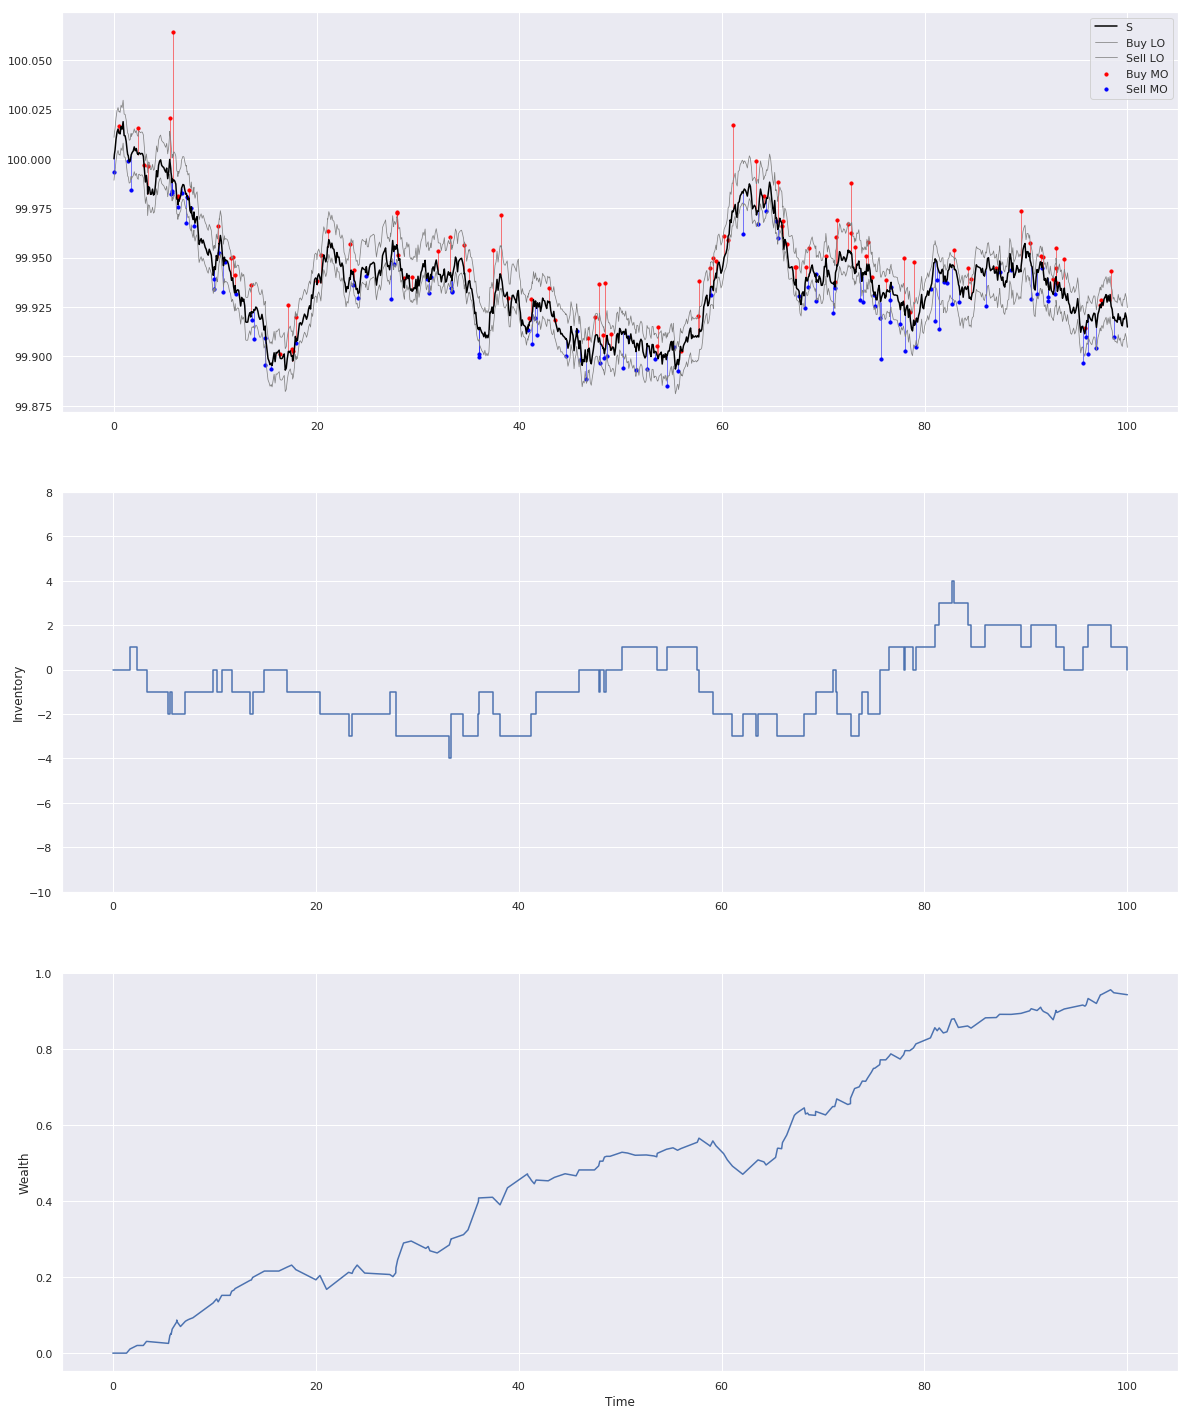

In [4]:
%matplotlib inline

import seaborn as sns
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

#set the parameters of the model
#if a variable is a pair, then the first and second elements are the minus/plus values, respectively
lmbda = (1., 1.)
kappa = 100.
q_lim = (-10, 10)
phi = 1 * 10**(-4)
alpha = 10**(-4)
sigma = 0.01
S0 = 100.

#set the parameters of the simulations
T = 100.
time_steps = 1000
times_subset = np.linspace(0, T, time_steps + 1)

#setup the matrix A (it isn't very big, so we won't bother with making it sparse)
q_vals = np.arange(q_lim[0], q_lim[1]+1)
q_to_index = {q: i for i, q in enumerate(q_vals)}
squared_q_vals = np.square(q_vals)
A = np.diag(-phi * kappa * squared_q_vals) + np.diag(lmbda[0] * np.exp(-1) * np.ones(len(q_vals)-1), 1) + np.diag(lmbda[1] * np.exp(-1) * np.ones(len(q_vals)-1), -1)
z = np.exp(-alpha * kappa * squared_q_vals)

def get_paths():
    wealth = 0.
    wealth_path = [0.]

    q = 0
    q_path = [0]
    
    #if we add two independent Poisson processes,
    #we get another Poisson process whose intensity is the sum of the intensities
    number_of_market_orders = np.random.poisson(sum(lmbda) * T)
    market_orders_times = np.sort(T * np.random.uniform(size=number_of_market_orders))
    
    #now we can mark the Poisson process according to whether the order is a buy or sell
    #this marker is equal to 1 if it's a buy, 0 if it's a sell
    markers = np.random.binomial(n=1, p=lmbda[1] / sum(lmbda), size=number_of_market_orders)

    unsorted_times = np.append(times_subset, market_orders_times)
    sort_indices = np.argsort(unsorted_times)
    times = unsorted_times[sort_indices]
    
    dt = np.diff(times, prepend=[0.])
    scaled_normals = sigma * np.sqrt(dt) * np.random.normal(loc=0, scale=1, size=len(dt))
    S = S0 + np.cumsum(scaled_normals)
    S_at_MOs = S[sort_indices >= len(times_subset)]
           
    #now we can figure out how deep the MOs walk the LOB
    MO_depths = -np.log(np.random.uniform(size=number_of_market_orders)) / kappa
    
    #this is just used for plotting
    depths = np.zeros((len(times), 2))
    
    #track where in times we are as we iterate through the MOs
    #this is used for computing the depths at all times, and then using that info for plotting
    times_index = 0

    #decide whether or not our limit orders are executed when an MO appears
    for i, t in enumerate(market_orders_times):
        delta_minus, delta_plus, times_index = compute_depths(t, q, times_index, times, depths)
        
        if q == q_lim[0] or q == q_lim[1]:
            continue
            
        if markers[i]:
            #buy MO, so we are the seller
            if MO_depths[i] >= delta_plus:
                #our LO is executed
                q -= 1
                #print('buy MO executed: t={},price={},q={}'.format(t, S_at_MOs[i] + delta_plus, q))
                wealth += S_at_MOs[i] + delta_plus
        else:
            #sell MO, so we are the buyer
            if MO_depths[i] >= delta_minus:
                #our LO is executed
                q += 1
                #print('sell MO executed: t={},price={},q={}'.format(t, S_at_MOs[i] - delta_minus, q))
                wealth -= S_at_MOs[i] - delta_minus
        q_path.append(q)
        wealth_path.append(wealth + q * (S_at_MOs[i] - alpha * q))
    
    delta_minus, delta_plus, times_index = compute_depths(times[-1], q, times_index, times, depths)
    wealth += q * (S[-1] - alpha * q)
    q = 0
    wealth_path.append(wealth)
    q_path.append(q)

    return times, S, market_orders_times, markers, MO_depths, S_at_MOs, depths, q_path, wealth_path
    
def compute_depths(t, q, times_index, times, depths):
    while times_index < len(times) and times[times_index] <= t:
        h = np.log(expm(A*(T-times[times_index])).dot(z)) / kappa
        delta_plus = 1 / kappa - h[q_to_index[q-1]] + h[q_to_index[q]]
        delta_minus = 1 / kappa - h[q_to_index[q+1]] + h[q_to_index[q]]
        depths[times_index,0] = delta_minus
        depths[times_index,1] = delta_plus
        times_index += 1
        
    return delta_minus, delta_plus, times_index
    
times, S, market_orders_times, markers, MO_depths, S_at_MOs, depths, q_path, wealth_path = get_paths()

sns.set()
plt.rcParams["figure.figsize"] = (20,25)

#create the first plot showing the midprice and the MOs
plt.subplot(3, 1, 1)

#plot the midprice
plt.plot(times, S, c='black', label='S')

#plot the buy MOs
buy_times = np.extract(markers, market_orders_times)
buy_prices = np.extract(markers, S_at_MOs + MO_depths)
plt.scatter(buy_times, buy_prices, c='red', s=10, label='Buy MO')
plt.vlines(buy_times, buy_prices, np.extract(markers, S_at_MOs), colors='red', linewidth=0.5)

#plot the sell MOs
sell_markers = np.logical_not(markers)
sell_times = np.extract(sell_markers, market_orders_times)
sell_prices = np.extract(sell_markers, S_at_MOs - MO_depths)
plt.scatter(sell_times, sell_prices, c='blue', s=10, label='Sell MO')
plt.vlines(sell_times, np.extract(sell_markers, S_at_MOs), sell_prices, colors='blue', linewidth=0.5)

#plot our buy LOs
plt.plot(times, S - depths[:,0], c='grey', label='Buy LO', linewidth=0.75)

#plot our posted sell LOs
plt.plot(times, S + depths[:,1], c='grey', label='Sell LO', linewidth=0.75)

plt.legend()

#create the second plot showing our inventory
plt.subplot(3, 1, 2)
q_times = np.concatenate(([0], market_orders_times, [T]))
plt.step(q_times, q_path, where='post')
plt.yticks(range(q_lim[0], q_lim[1], 2))
plt.ylabel('Inventory')

#create the third plot showing our wealth
#we compute the wealth path by assuming we liquidate our inventory at that point in time,
#it is only recomputed when an MO appears
plt.subplot(3, 1, 3)
wealth_times = np.concatenate(([0], market_orders_times, [T]))
plt.plot(wealth_times, wealth_path)
plt.xlabel('Time')
plt.ylabel('Wealth')

plt.show()